# Figure 4
Data is assumed to be in the folder "../../data/sequencing_runs/" if that is not true change below

## setup

In [1]:
# imports
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sys

from qmap_paper.titration import normalize_data, normalized_hill_equation, compute_mg_1_2
from qmap_paper.plotting import publication_style_ax, publication_scatter, plot_mg_titration_fit

# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["figure.facecolor"] = "white"

### extra functions

In [2]:
def stringify_parameters(p):
    """
    Converts the given parameters into a string representation.

    Args:
        p (list): A list of parameters [Kd, n, Bmax].

    Returns:
        str: A string representation of the parameters in the format "Kd: {Kd}, n: {n}, Bmax: {Bmax}".
    """
    return f"Kd: {p[0]:.3f}, n: {p[1]:.3f}, Bmax: {p[2]:.3f}"

In [3]:
# assume this is where the data is change if not true
DATA_PATH = "../../data/sequencing_runs/"

In [4]:
df_wt_mg = pd.read_json(f"{DATA_PATH}/processed/wt_mg_titra.json")
df_wt_buff = pd.read_json(f"{DATA_PATH}/processed/wt_buffer_titra.json")
df_mttr6_muts = pd.read_json(f"{DATA_PATH}/processed/mttr6_muts_titra.json")
df_mttr6_full = pd.read_json(f"{DATA_PATH}/processed/mttr6_data_full.json")

## data info

In [5]:
df_wt_mg["df_type"] = "df_wt_mg"
df_wt_buff["df_type"] = "df_wt_buff"
df_mttr6_muts["df_type"] = "df_mttr6_muts"
df_all = pd.concat([df_wt_mg, df_wt_buff, df_mttr6_muts])
# print all unique combos between run_name and exp_name
df_all.groupby(['df_type', 'run_name', 'exp_name', 'name']).count()

sequence  \
df_type       run_name                                 exp_name                                       name                                      
df_mttr6_muts 2023_02_02_minittr_6_uucg_Mg_titra_seq   2023_01_30_C013S_50mM_NaC_Mg_titra_CM          minittr_6_uucg_fixed                 16   
              2023_02_17_no_3_3_junc_Mg_titr_seq       2023_02_09_C013V_50mM_NaC_Mg_titra_CM          minittr_6_no_3_3_junc_fixed          16   
              2023_03_10_h1_3bp_longer_seq             2023_03_06_C013W_50mM_NaC_Mg_titra_CM          minittr_6_h1_3bp_longer_fixed        16   
              2023_03_13_no_tlr_Mg_titra_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_tlr_fixed               16   
              2023_03_14_no_ires_Mg_titr_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_ires_fixed              16   
              2023_03_15_h2_3bp_longer_Mg_titra_seq    2023_03_14_C013X_50mM_NaC_Mg_titra_CM          minittr_6_h2_3bp_longer_fixed        16   
              2023_03_22_h3_3bp_longer_Mg_titra_seq    2023_03_07_C013Y_50mM_NaC_Mg_titra_CM          minittr_6_h3_3bp_longer_fixed        16   
df_wt_buff    2022_07_20_minittr_Hepes-titra_seq       2022_07_18_C0117_100mM_buffer_Mg2+_titra_CM_BL minittr-6-2HP-ref                     8   
              2022_07_26_minittr-6-2HP-ref_buffer_seq  2022_07_25_C0117_NaC_Hep_titra_CM_BL           minittr-6-2HP-ref                    12   
                                                       2022_07_26_C0117_KCl_Tris_titra_CM_BL          minittr-6-2HP-ref                    12   
df_wt_mg      2022_07_27_minittr_50mM_NaC_Mg_titra_seq 2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM        minittr-6-2HP-ref                    15   
              2022_07_28_minittr_0.1M_NaC_Mg_titra_seq 2022_07_28_C0117_100mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_07_29_minittr_0.15M_NaC_Mg_titr_seq 2022_07_29_C0117_150mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_09_minittr_0.2M_NaC_Mg_titra_seq 2022_08_08_C0117_200mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_10_minittr_0.25M_NaC_Mg_titr_seq 2022_08_09_C0117_250mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_11_minittr_0.3M_NaC_Mg_titra_seq 2022_08_10_C0117_300mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   

                                                                                                                                     structure  \
df_type       run_name                                 exp_name                                       name                                       
df_mttr6_muts 2023_02_02_minittr_6_uucg_Mg_titra_seq   2023_01_30_C013S_50mM_NaC_Mg_titra_CM          minittr_6_uucg_fixed                  16   
              2023_02_17_no_3_3_junc_Mg_titr_seq       2023_02_09_C013V_50mM_NaC_Mg_titra_CM          minittr_6_no_3_3_junc_fixed           16   
              2023_03_10_h1_3bp_longer_seq             2023_03_06_C013W_50mM_NaC_Mg_titra_CM          minittr_6_h1_3bp_longer_fixed         16   
              2023_03_13_no_tlr_Mg_titra_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_tlr_fixed                16   
              2023_03_14_no_ires_Mg_titr_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_ires_fixed               16   
              2023_03_15_h2_3bp_longer_Mg_titra_seq    2023_03_14_C013X_50mM_NaC_Mg_titra_CM          minittr_6_h2_3bp_longer_fixed         16   
              2023_03_22_h3_3bp_longer_Mg_titra_seq    2023_03_07_C013Y_50mM_NaC_Mg_titra_CM          minittr_6_h3_3bp_longer_fixed         16   
df_wt_buff    2022_07_20_minittr_Hepes-titra_seq       2022_07_18_C0117_100mM_buffer_Mg2+_titra_CM_BL minittr-6-2HP-ref                      8   
              2022_07_26_minittr-6-2HP-ref_buffer_seq  2022_07

In [6]:
df_h1_longer = df_mttr6_muts[df_mttr6_muts["name"] == "minittr_6_h1_3bp_longer_fixed"]
df_h2_longer = df_mttr6_muts[df_mttr6_muts["name"] == "minittr_6_h2_3bp_longer_fixed"]
df_h3_longer = df_mttr6_muts[df_mttr6_muts["name"] == "minittr_6_h3_3bp_longer_fixed"]
df_wt = df_wt_mg[df_wt_mg["run_name"] == "2022_07_27_minittr_50mM_NaC_Mg_titra_seq"]


In [7]:
print([
    ["df_wt", len(df_wt)],
    ["df_h1_longer", len(df_h1_longer)],
    ["df_h2_longer", len(df_h2_longer)],
    ["df_h3_longer", len(df_h3_longer)],
])

[['df_wt', 15], ['df_h1_longer', 16], ['df_h2_longer', 16], ['df_h3_longer', 16]]


fit parameters for wild-type Kd: 0.229, n: 1.439, Bmax: 0.937 
error for parameters for wild-type Kd: 0.005, n: 0.038, Bmax: 0.004 


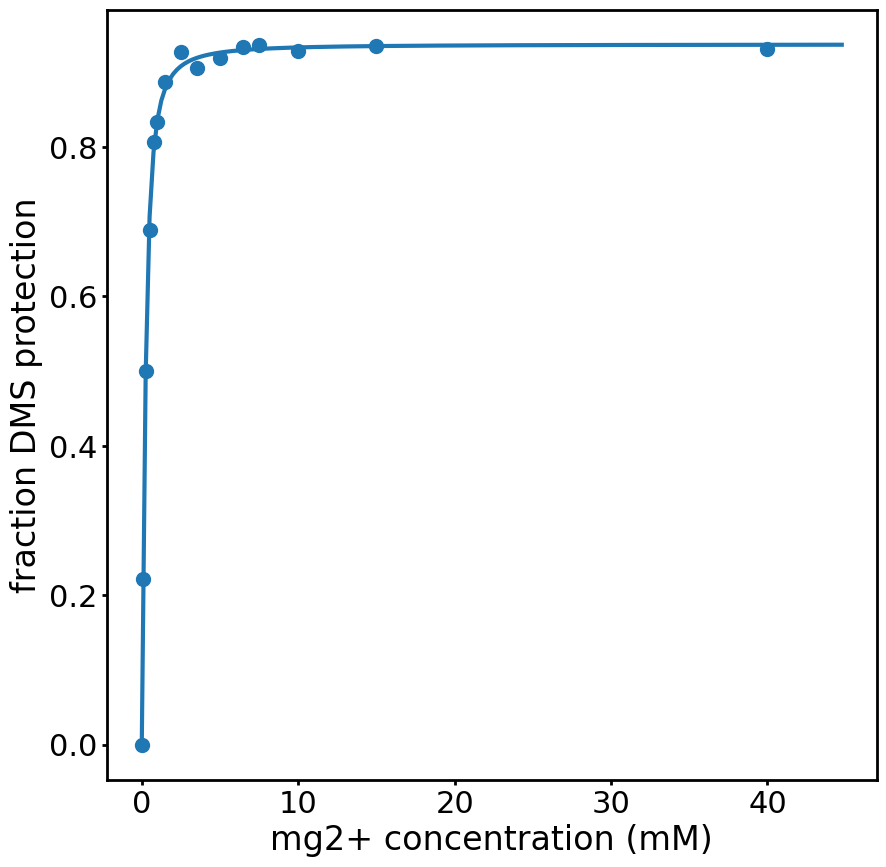

In [8]:
fig, ax = plt.subplots()
pfit, perr = compute_mg_1_2(df_wt["mg_conc"], df_wt["gaaa_avg"])
plot_mg_titration_fit(df_wt["mg_conc"], df_wt["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
#publication_titration_plot(df_wt, "50 mM", ax=ax)
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)
print(f"fit parameters for wild-type {stringify_parameters(pfit)} ")
print(f"error for parameters for wild-type {stringify_parameters(perr)} ")


### Figure 4B

fit parameters for h1-insert-mutant Kd: 1.113, n: 0.956, Bmax: 0.768 
error for parameters for h1-insert-mutant Kd: 0.320, n: 0.155, Bmax: 0.055 


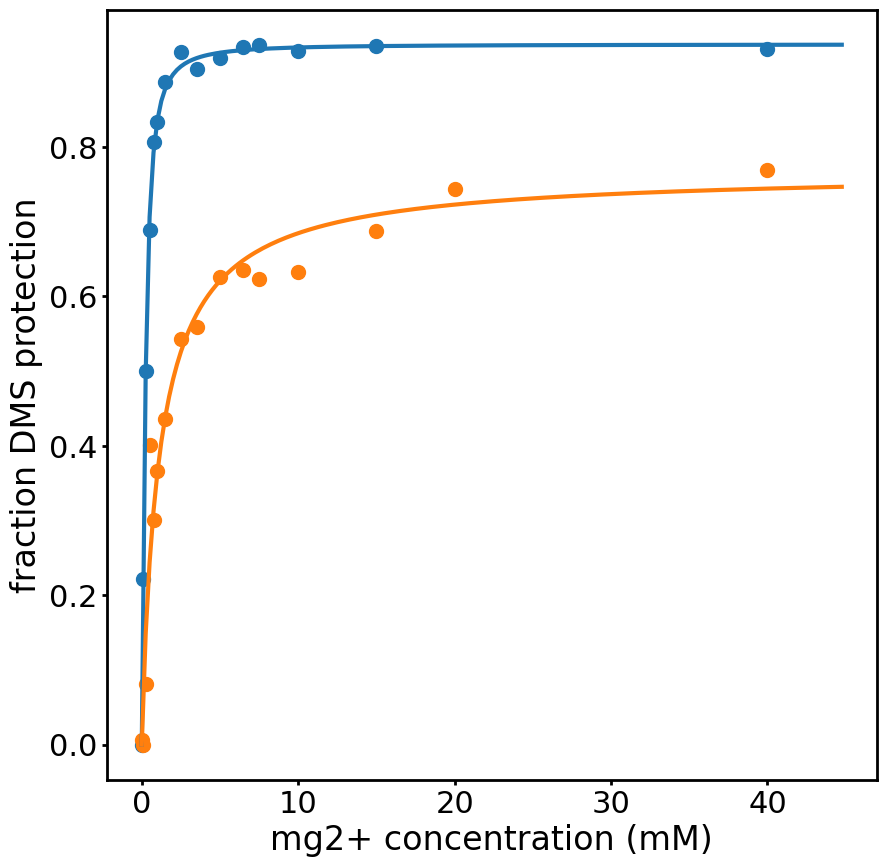

In [9]:
fig, ax = plt.subplots()
pfit, perr = compute_mg_1_2(df_wt["mg_conc"], df_wt["gaaa_avg"])
plot_mg_titration_fit(df_wt["mg_conc"], df_wt["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
pfit, perr = compute_mg_1_2(df_h1_longer["mg_conc"], df_h1_longer["gaaa_avg"])
plot_mg_titration_fit(df_h1_longer["mg_conc"], df_h1_longer["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for h1-insert-mutant {stringify_parameters(pfit)} ")
print(f"error for parameters for h1-insert-mutant {stringify_parameters(perr)} ")
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)


fit parameters for h2-insert-mutant Kd: 1.336, n: 1.247, Bmax: 0.706 
error for parameters for h2-insert-mutant Kd: 0.155, n: 0.138, Bmax: 0.027 


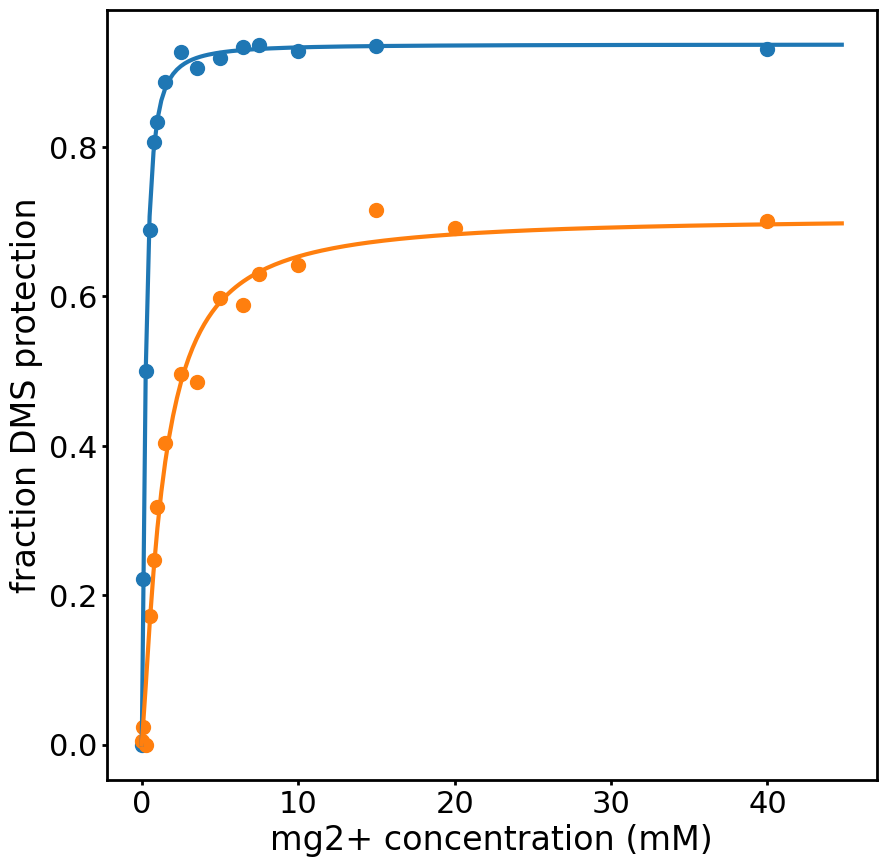

In [10]:
fig, ax = plt.subplots()
pfit, perr = compute_mg_1_2(df_wt["mg_conc"], df_wt["gaaa_avg"])
plot_mg_titration_fit(df_wt["mg_conc"], df_wt["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
pfit, perr = compute_mg_1_2(df_h2_longer["mg_conc"], df_h2_longer["gaaa_avg"])
plot_mg_titration_fit(df_h2_longer["mg_conc"], df_h2_longer["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for h2-insert-mutant {stringify_parameters(pfit)} ")
print(f"error for parameters for h2-insert-mutant {stringify_parameters(perr)} ")
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)

fit parameters for h3-insert-mutant Kd: 0.584, n: 1.354, Bmax: 0.880 
error for parameters for h3-insert-mutant Kd: 0.032, n: 0.099, Bmax: 0.015 


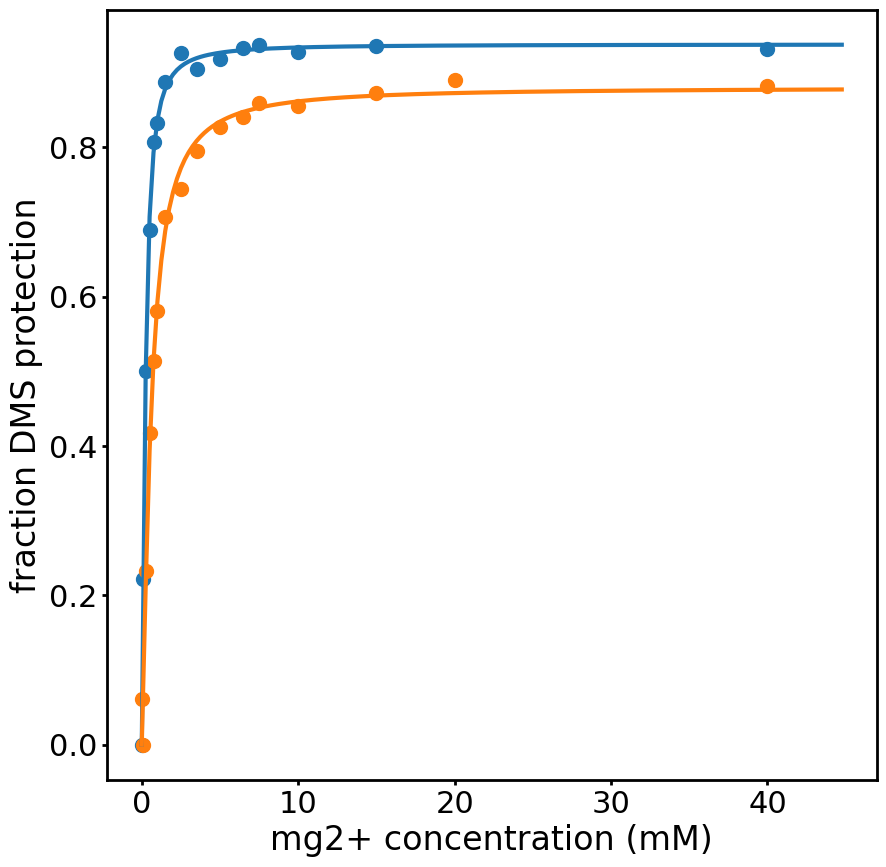

In [11]:
fig, ax = plt.subplots()
pfit, perr = compute_mg_1_2(df_wt["mg_conc"], df_wt["gaaa_avg"])
plot_mg_titration_fit(df_wt["mg_conc"], df_wt["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
pfit, perr = compute_mg_1_2(df_h3_longer["mg_conc"], df_h3_longer["gaaa_avg"])
plot_mg_titration_fit(df_h3_longer["mg_conc"], df_h3_longer["gaaa_avg"], pfit[0], pfit[1], pfit[2], ax=ax)
print(f"fit parameters for h3-insert-mutant {stringify_parameters(pfit)} ")
print(f"error for parameters for h3-insert-mutant {stringify_parameters(perr)} ")
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)